In [11]:
import pandas as pd
import numpy as np
df = pd.read_csv("questions.csv")



In [4]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
374286,374286,732294,732295,Who was the worst among Shakuni and Kans ?,What is the origin story of Shakuni's name?,0
367891,367891,336846,720018,Is it a legal requirement to have a front lice...,Why do some states require license plates on t...,0
348231,348231,682292,682293,Is there any tricks for straight lines mcqs?,Are there any underlying psychological tricks...,0
264766,264766,520920,520921,What is the worlds favourite colour?,Is there a favourite colour?,0
175208,175208,346142,346143,What are some mind blowing facts about Gautama...,What are some mind-blowing facts about Gautama...,1


In [6]:
df.shape

(404351, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [13]:
df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


In [18]:
df = df.dropna()


In [19]:
df.duplicated().sum()

np.int64(0)

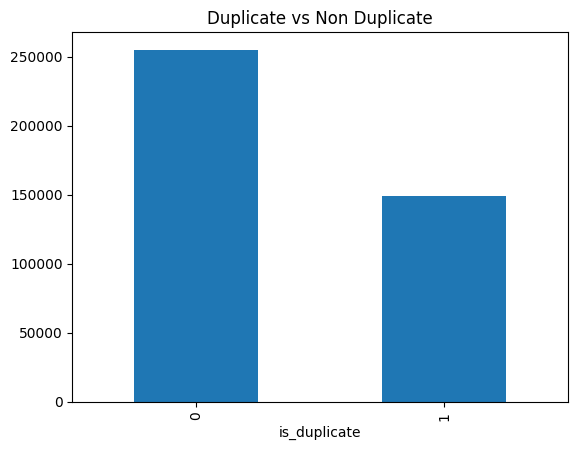

In [20]:
import matplotlib.pyplot as plt

df['is_duplicate'].value_counts().plot(kind='bar')
plt.title("Duplicate vs Non Duplicate")
plt.show()


In [21]:
# Repeated questions

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 789795
Number of questions getting repeated 13698


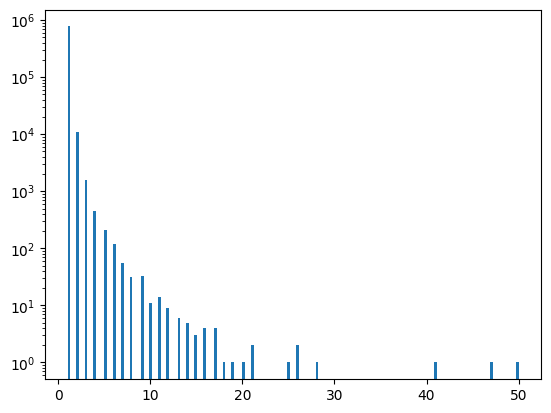

In [22]:
# Repeated questions histogram

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

# **Text Cleaning**

In [23]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['question1'] = df['question1'].apply(clean_text)
df['question2'] = df['question2'].apply(clean_text)


# **Stopword Removal + Lemmatization**

In [24]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Feature Engineering**

In [25]:
def word_overlap(q1, q2):
    s1 = set(q1.split())
    s2 = set(q2.split())
    return len(s1 & s2)

df['q1_len'] = df['question1'].apply(lambda x: len(x.split()))
df['q2_len'] = df['question2'].apply(lambda x: len(x.split()))

df['len_diff'] = abs(df['q1_len'] - df['q2_len'])

df['word_overlap'] = df.apply(
    lambda x: word_overlap(x['question1'], x['question2']), axis=1
)


# **EDA on New Features**

In [26]:
df[['q1_len', 'q2_len', 'len_diff', 'word_overlap']].describe()


,q1_len,q2_len,len_diff,word_overlap
count,404348.000000,404348.000000,404348.000000,404348.000000
mean,5.511208,5.584675,1.898236,2.600438
std,2.976536,3.304243,2.494017,1.682732
min,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,0.000000,2.000000
50%,5.000000,5.000000,1.000000,2.000000
75%,7.000000,7.000000,2.000000,3.000000
max,54.000000,107.000000,101.000000,24.000000


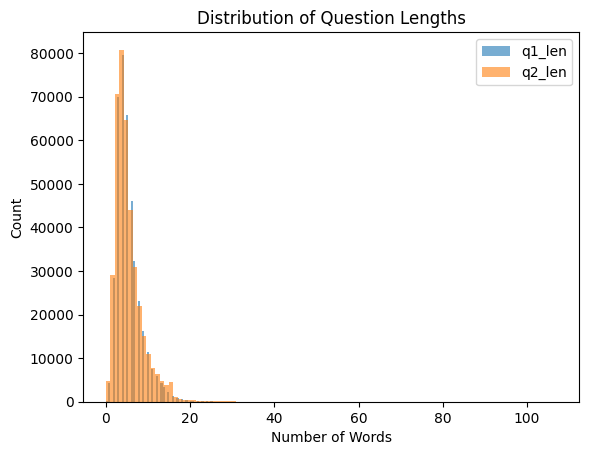

In [40]:
plt.hist(df['q1_len'], bins=100, alpha=0.6, label='q1_len')
plt.hist(df['q2_len'], bins=100, alpha=0.6, label='q2_len')
plt.legend()
plt.title("Distribution of Question Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()


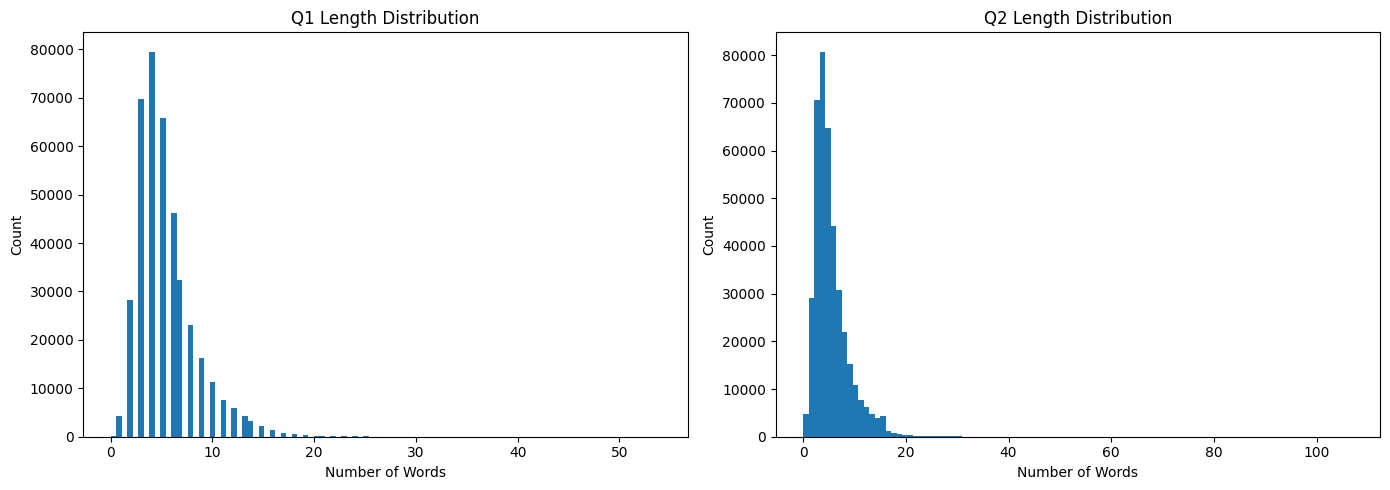

In [46]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].hist(df['q1_len'], bins=100)
axes[0].set_title("Q1 Length Distribution")
axes[0].set_xlabel("Number of Words")
axes[0].set_ylabel("Count")

axes[1].hist(df['q2_len'], bins=100)
axes[1].set_title("Q2 Length Distribution")
axes[1].set_xlabel("Number of Words")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


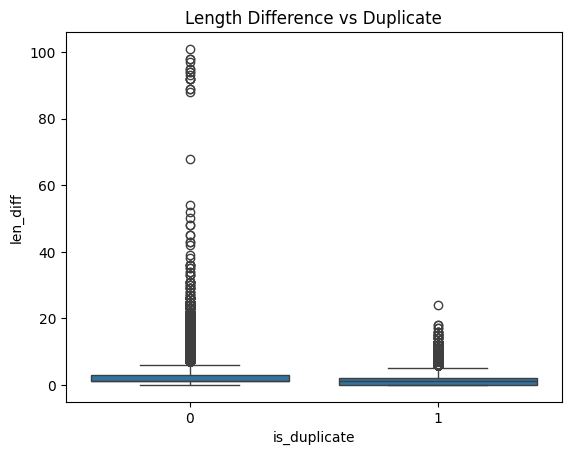

In [28]:
import seaborn as sns

sns.boxplot(x='is_duplicate', y='len_diff', data=df)
plt.title("Length Difference vs Duplicate")
plt.show()


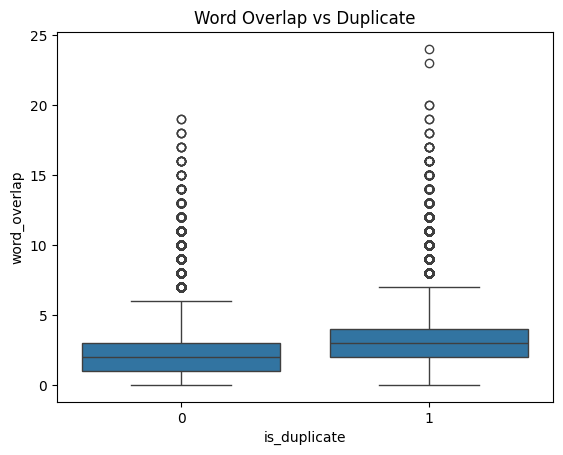

In [29]:
sns.boxplot(x='is_duplicate', y='word_overlap', data=df)
plt.title("Word Overlap vs Duplicate")
plt.show()


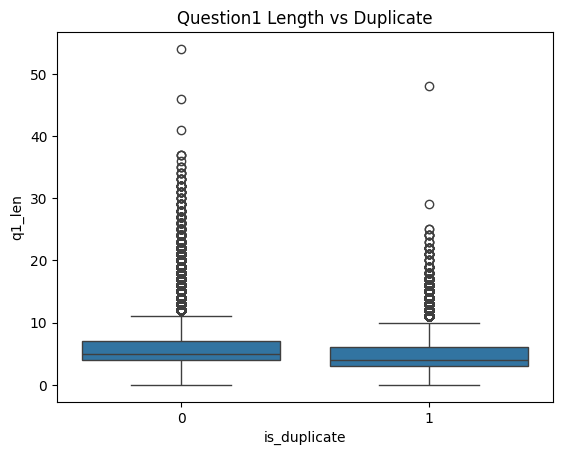

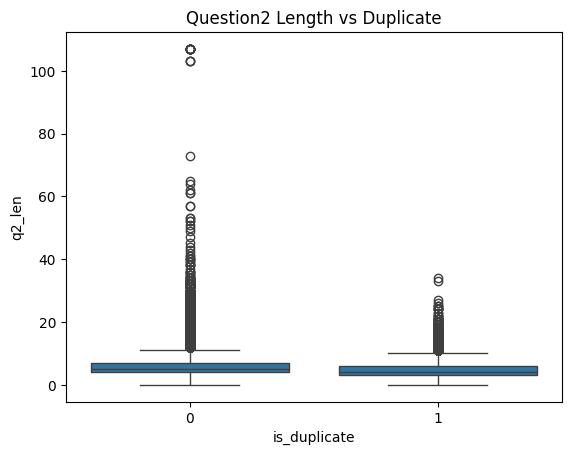

In [30]:
sns.boxplot(x='is_duplicate', y='q1_len', data=df)
plt.title("Question1 Length vs Duplicate")
plt.show()

sns.boxplot(x='is_duplicate', y='q2_len', data=df)
plt.title("Question2 Length vs Duplicate")
plt.show()


# **Correlation Check**

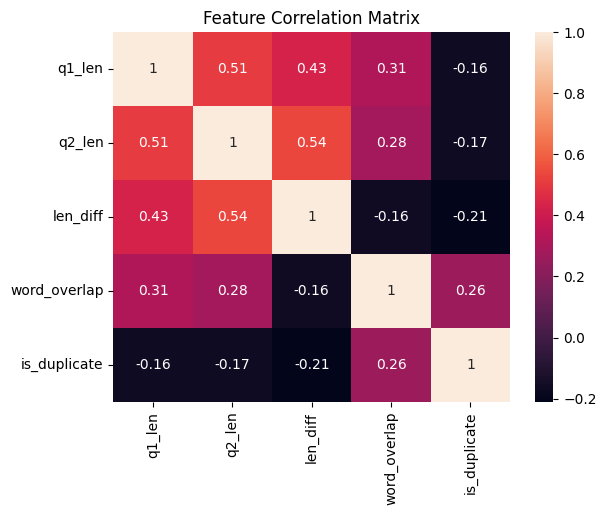

In [34]:
df[['q1_len', 'q2_len', 'len_diff', 'word_overlap', 'is_duplicate']].corr()
sns.heatmap(
    df[['q1_len', 'q2_len', 'len_diff', 'word_overlap', 'is_duplicate']].corr(),
    annot=True
)
plt.title("Feature Correlation Matrix")
plt.show()


# **TF-IDF Vectorization**

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=30000)

q1_tfidf = tfidf.fit_transform(df['question1'])
q2_tfidf = tfidf.transform(df['question2'])


In [48]:
import scipy.sparse as sp

extra_features = df[['len_diff', 'word_overlap']]

X = sp.hstack((q1_tfidf, q2_tfidf, extra_features.values))
y = df['is_duplicate']


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [50]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [53]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(classification_report(y_test, y_pred))


Accuracy: 0.7835785829108446
              precision    recall  f1-score   support

           0       0.81      0.86      0.83     51240
           1       0.73      0.65      0.69     29630

    accuracy                           0.78     80870
   macro avg       0.77      0.76      0.76     80870
weighted avg       0.78      0.78      0.78     80870



In [59]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Training accuracy
y_train_pred = model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

# Validation/Test accuracy
y_test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_acc)
print("Validation/Test Accuracy:", test_acc)


Training Accuracy: 0.8108341216404207
Validation/Test Accuracy: 0.7835785829108446


In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83     51240
           1       0.73      0.65      0.69     29630

    accuracy                           0.78     80870
   macro avg       0.77      0.76      0.76     80870
weighted avg       0.78      0.78      0.78     80870



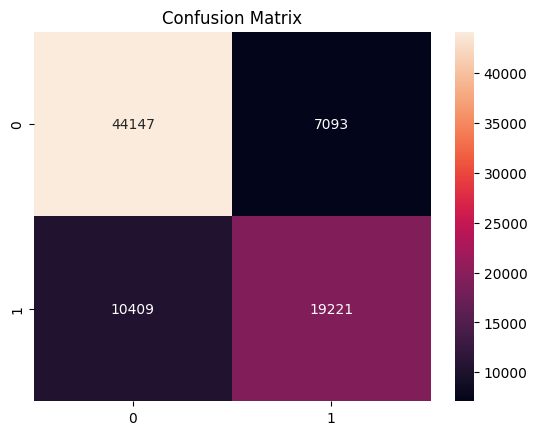

In [61]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()


In [62]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [63]:
# Train accuracy
rf_train_pred = rf_model.predict(X_train)
rf_train_acc = accuracy_score(y_train, rf_train_pred)

# Validation/Test accuracy
rf_test_pred = rf_model.predict(X_test)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

print("🌲 Random Forest Train Accuracy:", rf_train_acc)
print("🌲 Random Forest Validation/Test Accuracy:", rf_test_acc)

print(classification_report(y_test, rf_test_pred))


🌲 Random Forest Train Accuracy: 0.8794415694421259
🌲 Random Forest Validation/Test Accuracy: 0.7949425003091382
              precision    recall  f1-score   support

           0       0.81      0.88      0.84     51240
           1       0.75      0.66      0.70     29630

    accuracy                           0.79     80870
   macro avg       0.78      0.77      0.77     80870
weighted avg       0.79      0.79      0.79     80870

